### 网格交易回测
静态等差网格

策略逻辑：
- 假设初始资金量为w0，网格数量为n_grid，网格距离为d_grid，maker交易手续费为tx
- 初始每个网格, limit单的资金量为 w0/n_grid
- 根据当前1分钟的close价格（c_t0），设置网格【上下摆limit单】
- 下1分钟的close(c_t1)和c_t0之间的limit单，视为成交
- 记录当前仓位w_t1，每一次价格变化，网格重新发生变化。
- 价格超出区间范围，再平仓，调整网格

策略参数：
- 区间比率 r  
    - p_a < p_0 < p_b
    - 等差 -> p_a = (1-r)p_0; p_b = (1+r)p_0
    - 等比 -> p_a = 1/(1+r)p_0; p_b = (1+r)p_0
- 网格数量 (已知上下区间和网格量，就可以得到每个区间的宽度) n_grid
- 交易手续费

策略核心：
- 选出网格的压力位和阻力位。
    - 确定适当的压力位和阻力位，使价格大部分时间能够在压力位和阻力位之间波动。如果压力位和阻力位设置范围过大，会导致难以触发交易；如果压力位和阻力位设置范围过小，则会频繁触发交易。
- 合适的交易币对
    - 围绕均值来回波动，且波动性越大越好
- 怎么去区分不同行情，不同行情下，策略的变化和影响
    - 震荡行情 -> 
    - 趋势行情 -> 
- 网格交易，就是在一定区间内，做流动性

In [148]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from functions_processing_data import get_data


In [126]:
def get_price_range(p0, r, tp="arth"):
    if tp == "arth":
        pa = p0 * (1-r)
        pb = p0 * (1+r)
    elif tp == "geom":
        pa = p0 / (1+r)
        pb = p0 * (1+r)
    else:
        print("not right range type")
    
    return pa, pb

def get_grids(pa, pb, n_grid, tp="arth"):
    if tp == "arth":
        grids = np.linspace(pa, pb, n_grid+1)
    elif tp == "geom":
        grids = np.geomspace(pa, pb, n_grid+1)
    else:
        print("not right range type")
    return grids

# def get_quantity_on_one_grid(wealth, p0, r, tp="arth"):
#     pa, pb = get_price_range(p0, r, tp=tp)
#     grids = get_grids(pa, pb, n_grid, tp=tp)
#     quantity_on_one_grid = wealth / (np.sum(grids) - p0)
#     return quantity_on_one_grid 

# assuming the grids contains p0
def get_quantity_on_one_grid(wealth, grids, p0):
    quantity_on_one_grid = wealth / (np.sum(grids) - p0)
    return quantity_on_one_grid 

# 策略参数
p0 = 10
r = 0.2
n_grid = 6

pa, pb = get_price_range(p0,r,tp="arth")
grids = get_grids(pa, pb, n_grid, tp="arth")
print("arth")
print(pa, pb, grids)

pa, pb = get_price_range(p0,r,tp="geom")
grids = get_grids(pa, pb, n_grid, tp="geom")
print("arth")
print(pa, pb, grids)

# get_quantity_on_one_grid(10, p0,r)
pa, pb = get_price_range(p0,r,tp="arth")
grids = get_grids(pa, pb, n_grid, tp="arth")
get_quantity_on_one_grid(60, grids, p0)

arth
8.0 12.0 [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.        ]
arth
8.333333333333334 12.0 [ 8.33333333  8.85548808  9.41036029 10.         10.62658569 11.29243235
 12.        ]


1.0

array([ 8.33333333,  8.85548808,  9.41036029, 10.        , 10.62658569,
       11.29243235, 12.        ])

In [32]:
file_name = "binance_futures_DOTUSDT_20200101_20220322.csv"
df_data = get_data(file_name)
df_data = df_data.loc[df_data.index > pd.to_datetime("2022/1/1"), :]
df_data

,open,high,low,close,volume
Time,,,,,
2022-01-01 00:01:00,26.684,26.800,26.657,26.780,22505.7
2022-01-01 00:02:00,26.784,26.809,26.739,26.789,28272.3
2022-01-01 00:03:00,26.790,26.803,26.738,26.750,13909.6
2022-01-01 00:04:00,26.750,26.755,26.723,26.724,7502.6
2022-01-01 00:05:00,26.724,26.840,26.696,26.825,24512.5
...,...,...,...,...,...
2022-03-21 23:56:00,18.768,18.786,18.768,18.785,1306.3
2022-03-21 23:57:00,18.786,18.797,18.770,18.771,5116.1
2022-03-21 23:58:00,18.772,18.772,18.755,18.760,8218.1


In [157]:
 ["grid" + str(i) for i in range(n_grid+1)]

['grid0', 'grid1', 'grid2', 'grid3', 'grid4', 'grid5', 'grid6']

In [207]:
class StaticGridBT:
    def __init__(
        self,
        w0,
        r,
        n_grid,
        tp,
        stock_prices,
        tx_m=0.0001,
        tx_t=0.0002,
    ):
        ## parameters
        # inital wealth
        self.w0 = w0
        self.r = r
        self.n_grid = n_grid
        self.tp = tp
        # transaction cost[maker and taker]
        self.tx_m = tx_m
        self.tx_t = tx_t

        ## price data
        self.stock_prices = stock_prices
        p0 = self.stock_prices.iloc[0]

        ## on bar value
        self.positions = pd.Series(0, index=stock_prices.index)
        self.wealth = pd.Series(w0, index=stock_prices.index)
        self.pa, self.pb = get_price_range(p0, r, tp=tp)
        self.current_grid = get_grids(self.pa, self.pb, self.n_grid)
        self.last_transactions = np.array([p0])
        self.quantity_on_one_grid = get_quantity_on_one_grid(w0, self.current_grid, p0)
        
        self.grids_all = pd.DataFrame(0, index=stock_prices.index, columns= ["grid" + str(i) for i in range(n_grid+1)])
        self.grids_all.iloc[0, :] = self.current_grid
        

    def on_bar(self, i):
        current_price = self.stock_prices.iloc[i]
        last_price = self.stock_prices.iloc[i - 1]
        last_position = self.positions.iloc[i - 1]
        print("-" * 80)
        print(i)
        print(f"current_price: {current_price}")
        print(f"last_price: {last_price}")
        print(f"last_position: {last_position}")

        # price direction
        direction = 1 if current_price > last_price else -1
        print(f"current price direction: {direction}")

        # transactions
        if direction == 1:
            transactions = self.current_grid[
                (self.current_grid > last_price) & (self.current_grid < current_price)
            ]
            print(transactions)
            if (len(self.last_transactions) > 0):
                if np.min(self.last_transactions) in transactions:
                    # we ignore the minimum of last transactions
                    transactions = transactions[1:]
        else:
            transactions = self.current_grid[
                (self.current_grid > current_price) & (self.current_grid < last_price)
            ]
            print(transactions)
            if len(self.last_transactions) > 0:
                if np.max(self.last_transactions) in transactions:
                    # we ignore the maximum of last transactions
                    transactions = transactions[:-1]
                    
        print(f"last transactions: {self.last_transactions}")
        print(f"current transactions: {transactions}")

        # # calculate transactions volume
        # # volume direction is the negative of price direction
        # # volume < 0, short
        # # volume > 0, long
        # transactions_volume = len(transactions) * direction * (-1)
        
        # # calculate average transactions price
        # avg_transactions_price = np.mean(transactions)
        # avg_transactions_price = avg_transactions_price if avg_transactions_price else 0 

        if len(transactions) > 0:  
            # calculate transactions volume
            # volume direction is the negative of price direction
            # volume < 0, short
            # volume > 0, long
            transactions_volume = len(transactions) * direction * (-1)
            # calculate average transactions price
            avg_transactions_price = np.mean(transactions)
        else:
            transactions_volume, avg_transactions_price = 0, 0

        # calculate current position
        current_position = last_position + transactions_volume

        print(f"transactions_volume: {transactions_volume}")
        print(f"avg_transactions_price: {avg_transactions_price}")
        print(f"current_position: {current_position}")

        # calculate p&l from last step to this step
        # p&l = (current_price - last_price) * last_position
        #       + (current_price - avg_transactions_price) * transactions_volume
        # current_wealth = w_t + p&l
        current_wealth = (
            self.wealth.iloc[i - 1]
            + (current_price - last_price) * last_position * self.quantity_on_one_grid
            + (current_price - avg_transactions_price)
            * transactions_volume
            * self.quantity_on_one_grid
        )
        print(self.wealth.iloc[i-1])
        print(f"p&l: {current_wealth - self.wealth.iloc[i-1]}")
        print(f"current_wealth: {current_wealth}")

        # update
        if len(transactions) > 0:
            self.last_transactions = transactions
        # self.last_transactions = transactions
        self.last_position = current_position
        self.positions.iloc[i] = current_position
        self.wealth.iloc[i] = current_wealth
        self.grids_all.iloc[i, :] = self.current_grid

        # # update grid --> only change when price outside [pa, pb]
        if (current_price < self.pa) | (current_price > self.pb):
            # close all positions
            self.positions.iloc[i] = 0

            # update grid
            print("！" * 3)
            print("price out of grid range, need to update!")
            print(f"last quantity_on_one_grid: {self.quantity_on_one_grid}")
            
            self.pa, self.pb = get_price_range(current_price, r, tp=tp)
            self.current_grid = get_grids(self.pa, self.pb, self.n_grid)
            self.quantity_on_one_grid = get_quantity_on_one_grid(
                current_wealth, self.current_grid, current_price
            )
            
            print(f"new quantity_on_one_grid: {self.quantity_on_one_grid}")
            print(f"current_grid: {self.current_grid}")

    def run_on_bar(self):
        for i in range(1, len(self.wealth)):
            self.on_bar(i)
            
    def plot_results(self):
        fig, axs = plt.subplots(3, 1,figsize=(20,15),sharex=True)
        # price
        axs[0].plot(self.stock_prices)
        axs[0].plot(self.grids_all)
        axs[0].legend(["stock_prices"] + self.grids_all.columns.to_list())
        # position 
        axs[1].plot(self.positions)
        axs[1].legend(["positions"])
        # wealth 
        axs[2].plot(self.wealth)
        axs[2].legend(["wealth"])
        
        plt.savefig("results.png")



0    10.0
1    11.5
2     8.5
3     7.0
4    12.0
5     5.0
6     6.0
7     6.5
8     4.0
9    10.0
dtype: float64
--------------------------------------------------------------------------------
1
current_price: 11.5
last_price: 10.0
last_position: 0
current price direction: 1
[11.]
last transactions: [10.]
current transactions: [11.]
transactions_volume: -1
avg_transactions_price: 11.0
current_position: -1
60
p&l: -0.5
current_wealth: 59.5
--------------------------------------------------------------------------------
2
current_price: 8.5
last_price: 11.5
last_position: -1
current price direction: -1
[ 9. 10. 11.]
last transactions: [11.]
current transactions: [ 9. 10.]
transactions_volume: 2
avg_transactions_price: 9.5
current_position: 1
59.5
p&l: 1.0
current_wealth: 60.5
--------------------------------------------------------------------------------
3
current_price: 7.0
last_price: 8.5
last_position: 1
current price direction: -1
[8.]
last transactions: [ 9. 10.]
current transac

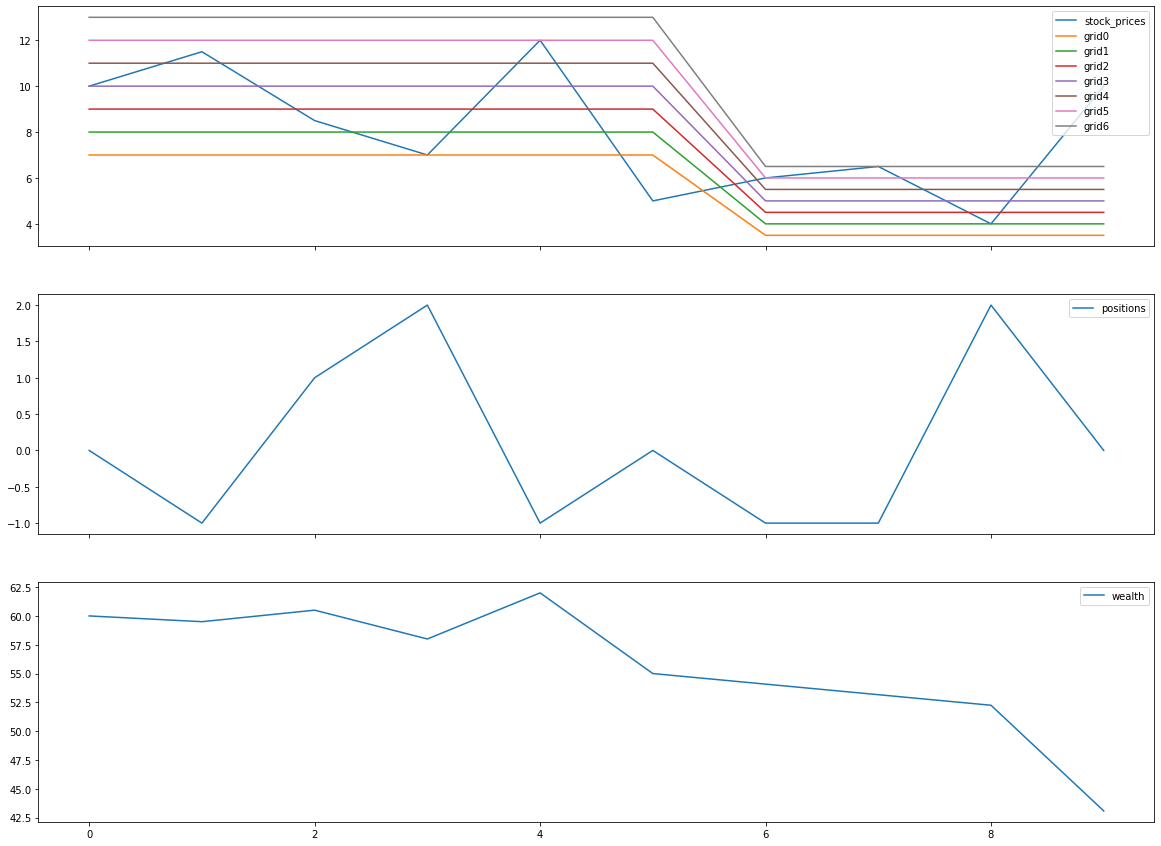

In [208]:
# 策略参数
w0 = 60
r = 0.3
n_grid = 6
tp = "arth"
data = pd.Series(np.array([10, 11.5, 8.5, 7, 12, 5, 6, 6.5, 4, 10]))
# data = pd.Series(np.array([10, 11.5, 8.5, 7, 12, 5, 6]))
# data = pd.Series(np.array([10, 9.5, 10.5, 10.5, 9.5]))

# test 
static_grid_bt = StaticGridBT(w0, r, n_grid, tp, data)
# print("static_grid_bt.positions: ", static_grid_bt.positions)
# static_grid_bt.pa, static_grid_bt.pb, static_grid_bt.last_grid

print(data)
static_grid_bt.run_on_bar()
static_grid_bt.plot_results()

In [205]:
static_grid_bt.current_grid, static_grid_bt.stock_prices.describe()

(array([ 7.,  8.,  9., 10., 11., 12., 13.]),
 count    10.000000
 mean      8.050000
 std       2.763351
 min       4.000000
 25%       6.125000
 50%       7.750000
 75%      10.000000
 max      12.000000
 dtype: float64)

--------------------------------------------------------------------------------
1
current_price: 26.75
last_price: 26.789
last_position: 0
current price direction: -1
[26.762211]
last transactions: [26.789]
current transactions: [26.762211]
transactions_volume: 1
avg_transactions_price: 26.762211
current_position: 1
60
p&l: -0.004558214192392995
current_wealth: 59.99544178580761
--------------------------------------------------------------------------------
2
current_price: 26.724
last_price: 26.75
last_position: 1
current price direction: -1
[26.735422]
last transactions: [26.762211]
current transactions: [26.735422]
transactions_volume: 1
avg_transactions_price: 26.735422
current_position: 2
59.99544178580761
p&l: -0.013969166448916326
current_wealth: 59.98147261935869
--------------------------------------------------------------------------------
3
current_price: 26.825
last_price: 26.724
last_position: 2
current price direction: 1
[26.735422 26.762211 26.789    26.815789]
last t

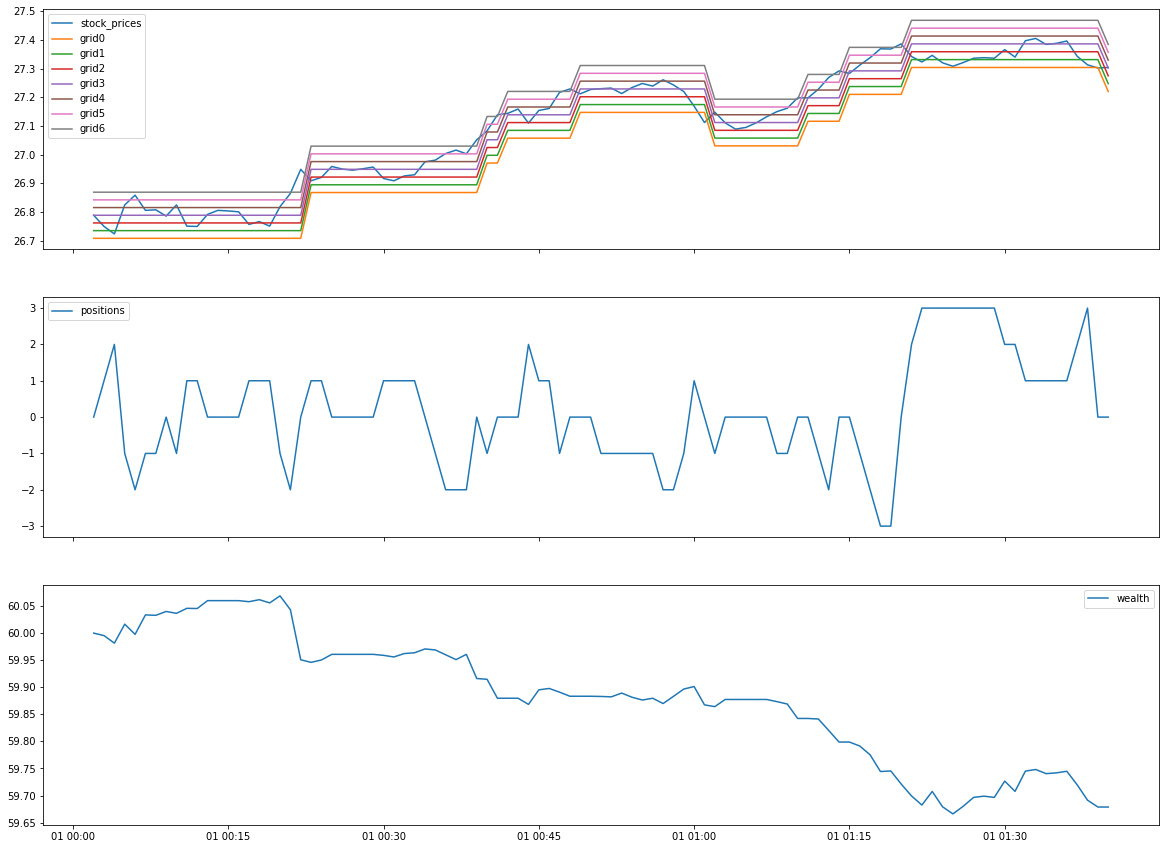

In [211]:
# 策略参数
w0 = 60
r = 0.003
n_grid = 6
tp = "arth"

# test 
static_grid_bt = StaticGridBT(w0, r, n_grid, tp, df_data.close.iloc[1:100])
# print("static_grid_bt.positions: ", static_grid_bt.positions)
# static_grid_bt.pa, static_grid_bt.pb, static_grid_bt.last_grid

static_grid_bt.run_on_bar()
static_grid_bt.plot_results()

In [65]:
# real data 
# static_grid_bt = StaticGridBT(w0, r, n_grid, "arth", df_data.close)



ValueError: zero-size array to reduction operation minimum which has no identity